In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import scipy 

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining a new function for time
def make_time(start):
    
    """time = "YYYY-MM" """
    
    time = pd.period_range(start=start , periods=120, freq="M") # 10 years
    time = [datetime.datetime(i.year, i.month, 16) for i in time]
    
    return time
    
time_1257 = make_time("1257-01") # make a time object to plot against

In [4]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [5]:
#setting file path
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'

coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
coupled_july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767']
coupled_jan = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]

In [6]:
all_precip_july = iris.cube.CubeList()
for job_id in coupled_july:

    dynamic_cube_july = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_precip.nc')
    precip_july = dynamic_cube_july.extract('precipitation_flux')[0]
    precip_mm_july = precip_july*86400 
    precip_mm_july.units='mm/day'
    all_precip_july.append(precip_mm_july)
    

In [7]:
all_precip_jan = iris.cube.CubeList()
for job_id in coupled_jan:

    dynamic_cube_jan = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_precip.nc')
    precip_jan = dynamic_cube_jan.extract('precipitation_flux')[0]
    precip_mm_jan = precip_jan*86400
    precip_mm_jan.units='mm/day'

    all_precip_jan.append(precip_mm_jan)

In [8]:
all_precip_control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_precip.nc')
    precip_control = control_cube.extract('precipitation_flux')[0]
    precip_mm_cntl = precip_control*86400
    precip_mm_cntl.units='mm/day'

    all_precip_control.append(precip_mm_cntl)

In [9]:
#merging list of cubes into single large cube
one_big_july = merge_cubes(all_precip_july)
one_big_jan = merge_cubes(all_precip_jan)
one_big_precip_control = merge_cubes(all_precip_control)

In [10]:
#mean control
mean_control = one_big_precip_control.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [11]:
mean_summer58 = one_big_precip_control[:,6:19].collapsed('time',iris.analysis.MEAN) #control for summer 1258
mean_summer57 = one_big_precip_control[:,0:13].collapsed('time',iris.analysis.MEAN) #control for summer 1257

#first summer post eruption July-58, Jan-57
summer58 = one_big_july[:,6:19].collapsed('time',iris.analysis.MEAN)
summer57 = one_big_jan[:,0:13].collapsed('time',iris.analysis.MEAN)
print(summer58.shape)

(9, 144, 192)


In [12]:
#ANOVA Analysis outputs p-values for each grid point
F, p = scipy.stats.f_oneway(mean_summer58.data,summer58.data)

p_july = p

F, p = scipy.stats.f_oneway(mean_summer57.data,summer57.data)

p_jan = p

In [13]:
anomally_july = one_big_july - mean_control.data
anomally_jan = one_big_jan - mean_control.data

In [14]:
#means collapsed over realisations and first 12 months post eruption
july_mean = anomally_july.collapsed('realization',iris.analysis.MEAN)[6:19].collapsed('time',iris.analysis.MEAN)
jan_mean = anomally_jan.collapsed('realization',iris.analysis.MEAN)[0:13].collapsed('time',iris.analysis.MEAN)

In [15]:
p_data_july = july_mean.copy()
p_data_july.data = p_july

p_data_jan = jan_mean.copy()
p_data_jan.data = p_jan

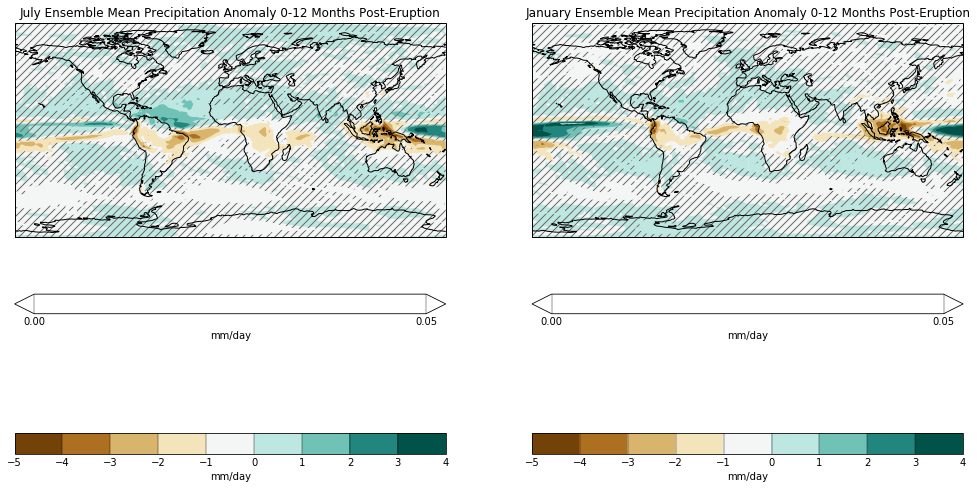

In [16]:
##July and Jan Means
levels=np.arange(-5,5,1)
plt.figure(figsize=(17,10))
mpl.rcParams['hatch.color'] = 'dimgrey'

plt.subplot(1,2,1)
qplt.contourf(july_mean, levels = levels, cmap='BrBG') 
qplt.contourf(p_data_july, levels =[0,0.05], hatches =['///', None], alpha = 0, extend='both')
plt.gca().coastlines() # add coastlines to the plot
plt.title('July Ensemble Mean Precipitation Anomaly 0-12 Months Post-Eruption')


plt.subplot(1,2,2)
qplt.contourf(jan_mean, levels = levels, cmap='BrBG') 
qplt.contourf(p_data_jan, levels =[0,0.05], hatches =['///', None], alpha = 0, extend='both')
plt.gca().coastlines() # add coastlines to the plot
plt.title('January Ensemble Mean Precipitation Anomaly 0-12 Months Post-Eruption')

plt.savefig('Hatched_July_Jan_Means.pdf')